There were two software solutions that were ran before this notebook was started. One, RJ ran STREME by MEMESUITE in order to find sequence that were enriched (found more in one set of sequences than the other) in our treatment set over a set of similarly sized control sequences (Control sequences discussed in logistic_regression.ipynb). 

Next, using that set of found enriched sequences, I ran FIMO from MEMESUITE in order to locate these sequences in each of the treatment sequences. At that point is where this notebook starts.

I am not considering those two bits of feature engineering to be a part of this project and so am not giving a very concrete overview of those software solutions.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
treatment_fimo = pd.read_csv('./TFBS Regression Modeling/trmt_fimo/fimo.tsv', header=0, sep='\t', comment='#')
narrowpeak = pd.read_csv('./TFBS Regression Modeling/dmel_s2_bampe_q01_peaks.narrowPeak', header=None, sep='\t', comment='#')

### Encoding based on Motif Appearances

#### Exploring the data:

How many entries and of what types?

In [4]:
treatment_fimo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62205 entries, 0 to 62204
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   motif_id          62205 non-null  object 
 1   motif_alt_id      62205 non-null  object 
 2   sequence_name     62205 non-null  object 
 3   start             62205 non-null  int64  
 4   stop              62205 non-null  int64  
 5   strand            62205 non-null  object 
 6   score             62205 non-null  float64
 7   p-value           62205 non-null  float64
 8   q-value           62205 non-null  float64
 9   matched_sequence  62205 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 4.7+ MB


Note that I have no missing entries. Next, note that the features I care about are just the sequence_name and the motif_alt_id.

In [5]:
treatment_fimo[['motif_alt_id', 'sequence_name']]

,motif_alt_id,sequence_name
0,STREME-12,X:5794883-5797178
1,STREME-12,3L:17576814-17578210
2,STREME-12,X:5794883-5797178
3,STREME-12,3L:17576814-17578210
4,STREME-12,2R:15744192-15745896
...,...,...
62200,STREME-17,2R:5599550-5600200
62201,STREME-17,2R:18651615-18653228
62202,STREME-17,3R:3394020-3394639
62203,STREME-17,2R:5168634-5169461


These are the only two features I'm interested in from that tsv file.

How many unique sequences?

In [6]:
sequences = list(treatment_fimo['sequence_name'].unique())
len(sequences)

2902

Out of the 28,896 total, we have only 2863 sequences. 

How many motifs?

In [7]:
unique_motifs = list(treatment_fimo['motif_alt_id'].unique())
unique_motifs.sort(key=lambda x: int(x.split('-')[-1]))
# We will sort the unique motifs list just so that it looks pretty.
len(unique_motifs)

36

Only 36! We must aggregate this data by both the sequence and then the motifs. Let us create a simple dictionary to aggregate our data:

In [8]:
motif_aggregation = dict.fromkeys(sequences, None)

for sequence in sequences:
    motif_aggregation[sequence] = dict.fromkeys(unique_motifs, 0)

first_key = list(motif_aggregation.keys())[0]
print(f'{first_key} has a dictionary of: {motif_aggregation[first_key]}')

X:5794883-5797178 has a dictionary of: {'STREME-1': 0, 'STREME-2': 0, 'STREME-3': 0, 'STREME-4': 0, 'STREME-5': 0, 'STREME-6': 0, 'STREME-7': 0, 'STREME-9': 0, 'STREME-10': 0, 'STREME-11': 0, 'STREME-12': 0, 'STREME-13': 0, 'STREME-14': 0, 'STREME-15': 0, 'STREME-16': 0, 'STREME-17': 0, 'STREME-18': 0, 'STREME-19': 0, 'STREME-20': 0, 'STREME-21': 0, 'STREME-22': 0, 'STREME-23': 0, 'STREME-25': 0, 'STREME-29': 0, 'STREME-31': 0, 'STREME-35': 0, 'STREME-36': 0, 'STREME-37': 0, 'STREME-38': 0, 'STREME-41': 0, 'STREME-42': 0, 'STREME-43': 0, 'STREME-44': 0, 'STREME-45': 0, 'STREME-46': 0, 'STREME-47': 0}


Let us fill this dictionary now.

In [9]:
for row_index, row in treatment_fimo.iterrows():
    count_dictionary = motif_aggregation[row['sequence_name']]
    count_dictionary[row['motif_alt_id']] += 1

print(f'{first_key} has a dictionary of: {motif_aggregation[first_key]}')

X:5794883-5797178 has a dictionary of: {'STREME-1': 0, 'STREME-2': 0, 'STREME-3': 0, 'STREME-4': 0, 'STREME-5': 0, 'STREME-6': 0, 'STREME-7': 0, 'STREME-9': 1, 'STREME-10': 1, 'STREME-11': 0, 'STREME-12': 30, 'STREME-13': 0, 'STREME-14': 1, 'STREME-15': 0, 'STREME-16': 0, 'STREME-17': 0, 'STREME-18': 0, 'STREME-19': 0, 'STREME-20': 0, 'STREME-21': 0, 'STREME-22': 1, 'STREME-23': 0, 'STREME-25': 0, 'STREME-29': 0, 'STREME-31': 2, 'STREME-35': 0, 'STREME-36': 0, 'STREME-37': 3, 'STREME-38': 0, 'STREME-41': 0, 'STREME-42': 0, 'STREME-43': 1, 'STREME-44': 30, 'STREME-45': 2, 'STREME-46': 0, 'STREME-47': 0}


Now let us create a pandas dictionary from these "rows" of counts we made. Remember! Since python 3.6 this is allowed because the insertion order is the same, and as such they key order for all of our dictionaries is the same.

In [10]:
column_names = list(motif_aggregation[first_key].keys())

all_rows = []
for key, row_dict in motif_aggregation.items():
    row_values = [key]
    for motif_name, appearances in row_dict.items():
        row_values.append(appearances)
    
    all_rows.append(row_values)

count_dataframe = pd.DataFrame(data=all_rows, columns=['sequence_name',*column_names])
print(f'Final shape of dataframe: {count_dataframe.shape}')
count_dataframe.head(2)

Final shape of dataframe: (2902, 37)


,sequence_name,STREME-1,STREME-2,STREME-3,STREME-4,STREME-5,STREME-6,STREME-7,STREME-9,STREME-10,...,STREME-36,STREME-37,STREME-38,STREME-41,STREME-42,STREME-43,STREME-44,STREME-45,STREME-46,STREME-47
0,X:5794883-5797178,0,0,0,0,0,0,0,1,1,...,0,3,0,0,0,1,30,2,0,0
1,3L:17576814-17578210,0,0,0,16,1,2,0,2,1,...,0,1,0,0,1,1,6,1,2,0


How many of each STREME motif are there? This might be interesting to go back to later, though I don't think I will have the time to.

In [11]:
count_dataframe.sum(axis=0)

sequence_name    X:5794883-57971783L:17576814-175782102R:157441...
STREME-1                                                      1390
STREME-2                                                      1076
STREME-3                                                      1310
STREME-4                                                      7480
STREME-5                                                      1340
STREME-6                                                      1585
STREME-7                                                       756
STREME-9                                                      2090
STREME-10                                                     1046
STREME-11                                                      428
STREME-12                                                     9872
STREME-13                                                      716
STREME-14                                                      967
STREME-15                                                     

In [12]:
summed_data = count_dataframe.sum()
summed_data['sequence_name'] = "count"
summed_df = pd.DataFrame(summed_data)
summed_df = summed_df.T
summed_df.columns
summed_df = summed_df.drop('sequence_name', axis=1)
summed_df
new_df = pd.DataFrame()
new_df['Motifs'] = summed_df.columns
new_df['Count'] = [value[0] for value in summed_df.T.values]


Text(0.5, 1.0, 'Different motif counts')

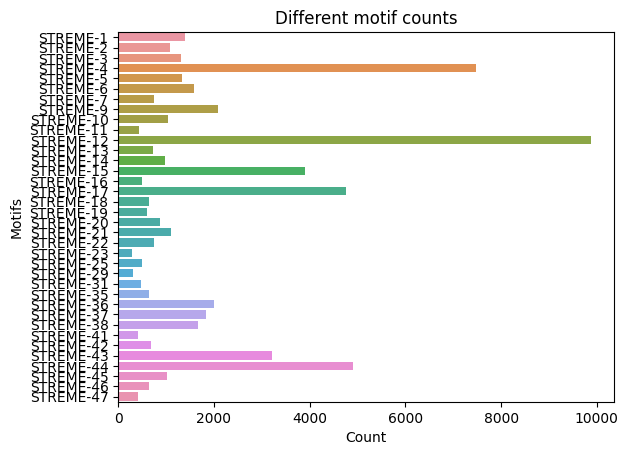

In [19]:
sns.barplot(data=new_df, y=new_df.Motifs, x=new_df.Count)
plt.title("Different motif counts")

Looking at this chart, it seems like there are some different motifs that have a lot more appearances. That will be looked at later. Do note that some of these (like STREME 12) might actually be a product of repeated sequence. I'm not sure if I'll look into this for the scope of this project, but it's something that I'm noting down.

Though, maybe some of these (even the smaller one) are related to signal output. That is the purpose of these notebooks.

Engineering the narrowpeak file in order to add it to the above dataframe

NOTE: I will look at the distribution of this variable in the other notebook: linear_regression

In [14]:
sequence_name_generated = [f'{chr.strip()}:{start}-{end}' for chr, start, end in zip(narrowpeak.iloc[:,0], narrowpeak.iloc[:,1], narrowpeak.iloc[:,2])]

In [15]:
narrowpeak_only_height_name = pd.DataFrame()
narrowpeak_only_height_name['sequence_name'] = sequence_name_generated
# Columns follow this format: https://genome.ucsc.edu/FAQ/FAQformat.html#format12
# We will use the 4th column (0 indexed), or score.
narrowpeak_only_height_name['signal_response'] = narrowpeak.iloc[:,4]
narrowpeak_only_height_name.head(3)

,sequence_name,signal_response
0,211000022278091:232-1074,36
1,211000022278785:515-1338,350
2,211000022278925:77-768,123


In [16]:
temp_groups = narrowpeak_only_height_name.groupby('sequence_name').max()
temp_groups.iloc[1000:1005, :]

,signal_response
sequence_name,
2R:8068591-8069363,210
2R:8144907-8146842,481
2R:8150427-8151097,48
2R:8237360-8238169,166
2R:8242236-8243053,189


Joining these dataframes based on sequence_name

In [17]:
joined_dataframe = count_dataframe.join(narrowpeak_only_height_name.set_index('sequence_name'), on='sequence_name')
joined_dataframe.head(3)

,sequence_name,STREME-1,STREME-2,STREME-3,STREME-4,STREME-5,STREME-6,STREME-7,STREME-9,STREME-10,...,STREME-37,STREME-38,STREME-41,STREME-42,STREME-43,STREME-44,STREME-45,STREME-46,STREME-47,signal_response
0,X:5794883-5797178,0,0,0,0,0,0,0,1,1,...,3,0,0,0,1,30,2,0,0,48
1,3L:17576814-17578210,0,0,0,16,1,2,0,2,1,...,1,0,0,1,1,6,1,2,0,654
2,2R:15744192-15745896,1,0,2,0,0,0,0,0,1,...,1,2,0,0,1,10,0,0,0,443


In [18]:
from functions import get_linear_regression_matrix

joined_df_function = get_linear_regression_matrix()
joined_df_function.head(3)

,sequence_name,STREME-1,STREME-2,STREME-3,STREME-4,STREME-5,STREME-6,STREME-7,STREME-9,STREME-10,...,STREME-37,STREME-38,STREME-41,STREME-42,STREME-43,STREME-44,STREME-45,STREME-46,STREME-47,signal_value
0,X:5794883-5797178,0,0,0,0,0,0,0,1,1,...,3,0,0,0,1,30,2,0,0,48
1,3L:17576814-17578210,0,0,0,16,1,2,0,2,1,...,1,0,0,1,1,6,1,2,0,654
2,2R:15744192-15745896,1,0,2,0,0,0,0,0,1,...,1,2,0,0,1,10,0,0,0,443


Just double checking my function is working and giving me the same output.